In [1]:
# w2v_skpgr_noW1.ipynb
#  2021.08.19
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

# Auxilary Functions

In [2]:
def remove_stop_words(corpus):
    stop_words = ['in','very','are','the','to','of','is', 'a', 'and',\
                  'on','will', 'be', 'и', 'он', 'этот', 'она']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    return results

# function to convert numbers to one hot vectors
def to_one_hot_encoding(dimention, index_of_1):
    one_hot_encoding = np.zeros(dimention).astype(int)
    one_hot_encoding[index_of_1] = 1
    return one_hot_encoding

# function to convert numbers to one hot TENSOR
def one_hot_encoding_tensor(dimention, index_of_1):
    one_hot_encoding = torch.zeros(dimention).int()
    one_hot_encoding[index_of_1] = 1
    return one_hot_encoding



# compute cosine distance
def print_cosine_distance(w1,w2,W):
    v1 = W[word2idx[w1]]
    if type(v1) == np.ndarray:
        tv1 = torch.tensor(v1)

    v2 = W[word2idx[w2]]
    if type(v2) == np.ndarray:
        tv2 = torch.tensor(v2)

    cos_sim = torch.dot(tv1,tv2)/(torch.norm(tv1)*torch.norm(tv2))
    print(f'cosine_dist ({w1},{w2}) = {cos_sim:.5}')
    return None


# PLOT WORDS
def plot_words_x_y(x1,x2, vocab, ttl, figfn='test.png', figsz=6, wcolor='red'):
    x_axis_min, x_axis_max = np.min(x1)-get_padding(x1), np.max(x1)+get_padding(x1)
    y_axis_min, y_axis_max = np.min(x2)-get_padding(x2), np.max(x2)+get_padding(x2)

    plt.close()
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (figsz,figsz)

    plt.scatter(x1, x2, c='yellow', s=500, alpha=0.9)
    for ix, word, x1i, x2i in zip(range(len(wcolor)), vocab, x1, x2):
        if word == 'кичлам':
            ax.annotate(word, (x1i,x2i ), fontsize=14, color='cyan' )
        else:
            ax.annotate(word, (x1i,x2i ), fontsize=18, color=wcolor[ix])

    # Plot Center
    plt.scatter([0], [0], c='g', marker='+', s=500, alpha=0.9)     
    plt.grid()
    plt.xlim(x_axis_min,x_axis_max)
    plt.ylim(y_axis_min,y_axis_max)
    
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=18)
    
    plt.title(ttl, fontsize=18)

    fig.savefig(fname=figfn, formatstr='png')
    plt.show()

def plot_words_v0(W, vocab, ttl, wcolor):
    # plot words according to their embedding
    x1 = W[:,0]
    x2 = W[:,1]
    # wrd =
    plot_words_x_y(x1,x2, vocab, ttl, wcolor=wcolor)

def get_padding(x):
    return 2*(np.max(x)-np.min(x))/10

# Prepare Text

In [3]:
text = "Fish swim in deep water. Ocean is very deep. Fish swim in darkness. \
          Birds are high in the sky. Birds fly very high. On a sunny day the sky is full of light."

# text = "Fish and water. Birds and sky."

# Text should have even number of sentences. This will help with illustration.
# Words in the 1st half will be 'red'.
# Words in the 2nd half of sentences must be 'cyan'.
print('TEXT = ', text)

corpus=[s.lower().strip() for s in text.split('.')][:-1]
corpus = remove_stop_words(corpus)
print('CLEAN CORPUS = ',corpus)
sentences = [s.split(' ') for s in corpus]
print('SENTENCES = ',sentences)

# GET VOCAB
vocab=[]
for ss in sentences:
  # print(ss)
  vocab += ss
    
vocab = sorted(set(vocab))
print('VOCABULARY = ', vocab)


# DICs mapping each word to a number and vice-versa
word2idx = {w: idx for (idx, w) in enumerate(vocab)}
idx2word = {idx: w for (idx, w) in enumerate(vocab)}
print('word2idx=', word2idx)
print('idx2word=', idx2word)


# COUNT WORDS
vocab_word_count = np.zeros(len(vocab))
for ss in sentences:
    for word in ss:
        idx = vocab.index(word) 
        vocab_word_count[idx] += 1
print('vocab_word_count = ',vocab_word_count)


# Create master DF for our data 
vocab_df = pd.DataFrame( columns=['input','color'] )

# assign colors
# ASSUME: corpus has even number of sentences. First half must be 'red'.
# Words in the second half of sentences must be 'cyan'
ix=0
for i, ss in zip(range(len(sentences)), sentences):
    wordcolor = 'red' if i<len(sentences)/2 else 'cyan'
    for w in ss:
        vocab_df.loc[ix]=[w, wordcolor]
        ix+=1
        
total_number_of_words = ix
vocab_df = vocab_df.drop_duplicates().sort_values(by='input').reset_index(drop=True)
vocab_df['count']=vocab_word_count
vocab_df['freq'] = vocab_df['count']/total_number_of_words
vocab_df1 = vocab_df.copy()

# CREATE one-hot encoding for each word
# ONE_HOT_DIM = len(vocab)
# print('\nONE_HOT_DIM = ', ONE_HOT_DIM)
# vocab_df1['one_hots'] = [to_one_hot_encoding(ONE_HOT_DIM,i) for i in range(ONE_HOT_DIM)]
# vocab_df1
# print('\nvocab_df1:')
# vocab_df1 
# vocab_df

TEXT =  Fish swim in deep water. Ocean is very deep. Fish swim in darkness.           Birds are high in the sky. Birds fly very high. On a sunny day the sky is full of light.
CLEAN CORPUS =  ['fish swim deep water', 'ocean deep', 'fish swim darkness', 'birds high sky', 'birds fly high', 'sunny day sky full light']
SENTENCES =  [['fish', 'swim', 'deep', 'water'], ['ocean', 'deep'], ['fish', 'swim', 'darkness'], ['birds', 'high', 'sky'], ['birds', 'fly', 'high'], ['sunny', 'day', 'sky', 'full', 'light']]
VOCABULARY =  ['birds', 'darkness', 'day', 'deep', 'fish', 'fly', 'full', 'high', 'light', 'ocean', 'sky', 'sunny', 'swim', 'water']
word2idx= {'birds': 0, 'darkness': 1, 'day': 2, 'deep': 3, 'fish': 4, 'fly': 5, 'full': 6, 'high': 7, 'light': 8, 'ocean': 9, 'sky': 10, 'sunny': 11, 'swim': 12, 'water': 13}
idx2word= {0: 'birds', 1: 'darkness', 2: 'day', 3: 'deep', 4: 'fish', 5: 'fly', 6: 'full', 7: 'high', 8: 'light', 9: 'ocean', 10: 'sky', 11: 'sunny', 12: 'swim', 13: 'water'}
vocab_wor

# Build Training Data Word Pairs

In [4]:
# initialize dictionary of context words
context_words = {}
for w in vocab:
    context_words[w] = []

WINDOW_SIZE = 2
data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) :\
                                 min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])
                context_words[word].append(neighbor)

df_context_words = pd.DataFrame({'input': list(context_words.keys()),   \
                                 'c_words': list(context_words.values())})
df_context_words['num_c_words_pairs'] = [ len(wrds) for wrds in list(context_words.values()) ]
df_context_words['set_c_words'] = [ set(wrds) for wrds in list(context_words.values()) ]
df_context_words['num_c_words'] = [ len(set(wrds)) for wrds in list(context_words.values()) ]

df = pd.DataFrame(data, columns = ['input', 'label'])

In [5]:
vocab_df2 = vocab_df.merge( df_context_words, how='outer',on=['input'] )
vocab_df2

,input,color,count,freq,c_words,num_c_words_pairs,set_c_words,num_c_words
0,birds,cyan,2.0,0.10,"[high, sky, fly, high]",4,"{high, fly, sky}",3
1,darkness,red,1.0,0.05,"[fish, swim]",2,"{swim, fish}",2
2,day,cyan,1.0,0.05,"[sunny, sky, full]",3,"{full, sunny, sky}",3
3,deep,red,2.0,0.10,"[fish, swim, water, ocean]",4,"{swim, ocean, fish, water}",4
4,fish,red,2.0,0.10,"[swim, deep, swim, darkness]",4,"{swim, deep, darkness}",3
5,fly,cyan,1.0,0.05,"[birds, high]",2,"{high, birds}",2
6,full,cyan,1.0,0.05,"[day, sky, light]",3,"{sky, light, day}",3
7,high,cyan,2.0,0.10,"[birds, sky, birds, fly]",4,"{birds, fly, sky}",3
8,light,cyan,1.0,0.05,"[sky, full]",2,"{full, sky}",2
9,ocean,red,1.0,0.05,[deep],1,{deep},1


In [6]:
df

,input,label
0,fish,swim
1,fish,deep
2,swim,fish
3,swim,deep
4,swim,water
5,deep,fish
6,deep,swim
7,deep,water
8,water,swim
9,water,deep


# Simplified Skip-Gram Model (no W1)

In [7]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import time

EMBEDDING_DIMENSION = 2
W0 = Variable(torch.randn(len(vocab), EMBEDDING_DIMENSION).float(), requires_grad=True)
W0_init = torch.clone( W0 )

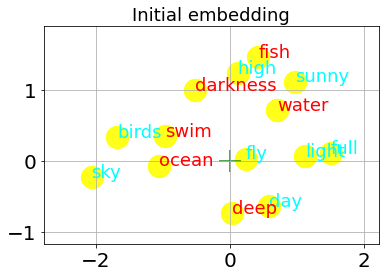

In [8]:
plot_words_v0(W0_init.cpu().detach().numpy(), vocab, ttl='Initial embedding', wcolor=vocab_df.color)

# Main Loop


In [9]:
U_array = []

In [10]:
EPOCHS = 1000
LEARNING_RATE = 0.001
pair_ix = 24  # index of contect pair for prints
sttime = time.time()

# PyTorch Training
for epoch in range(EPOCHS):
    loss_val = 0
    U = 0
    for i in range(len(df)):
        
        w_input    = df.input[i]
        w_context    = df.label[i]
        
        w_input_ix = word2idx[w_input]
        w_context_ix = word2idx[w_context]
        
        w_input_embed = W0[word2idx[df.input[i]],:]        
        dot_products = torch.matmul( w_input_embed, torch.transpose(W0, 0, 1) )      
        log_softmax = F.log_softmax(dot_products, dim=0)
        
        ix = torch.tensor([w_context_ix])
        U_increment = torch.mul( F.nll_loss( log_softmax.view(1,-1), ix ), torch.tensor([-1.0]) )
        U += U_increment.item()
        
        if (epoch % 300 == 0) & (w_input==df.input[pair_ix]) & (w_context==df.label[pair_ix]):
            if epoch == 0:
                print(f'    w_input={w_input}, w_input_ix={w_input_ix}, w_context={w_context}, w_context_ix={w_context_ix} ')    
            print( f'  * epoch={epoch},  i={i}, U=',np.round(U,4),
                 '   U_increment=',  round(U_increment.cpu().detach().numpy()[0],3)  )
        
        U_increment.backward()
        W0.data += LEARNING_RATE * W0.grad.data
        W0.grad.data.zero_()
        
    U_array.append(U)

endtime = time.time()
ttl = f'Epochs={len(U_array)}, LR={LEARNING_RATE}, time={int(endtime-sttime)} sec'

print('Finished training with: U=',np.round(U,4),'\n', ttl)

    w_input=birds, w_input_ix=0, w_context=fly, w_context_ix=5 
  * epoch=0,  i=24, U= -80.5604    U_increment= -4.604
  * epoch=300,  i=24, U= -57.3232    U_increment= -2.25
  * epoch=600,  i=24, U= -50.0069    U_increment= -1.557
  * epoch=900,  i=24, U= -45.6888    U_increment= -1.521
Finished training with: U= -77.3065 
 Epochs=1000, LR=0.001, time=32 sec


['birds', 'darkness', 'day', 'deep', 'fish', 'fly', 'full', 'high', 'light', 'ocean', 'sky', 'sunny', 'swim', 'water']


,input,color,count,freq,embedding
0,birds,cyan,2.0,0.10,"[-1.4259163, -0.8504919]"
1,darkness,red,1.0,0.05,"[0.09278854, 1.4958923]"
2,day,cyan,1.0,0.05,"[0.94129246, -1.0665203]"
3,deep,red,2.0,0.10,"[-0.11431043, 1.5789834]"
4,fish,red,2.0,0.10,"[0.06507354, 1.8014758]"
5,fly,cyan,1.0,0.05,"[-1.5134242, -0.26499227]"
6,full,cyan,1.0,0.05,"[0.97893864, -1.0701636]"
7,high,cyan,2.0,0.10,"[-1.4260329, -0.84881854]"
8,light,cyan,1.0,0.05,"[0.7554576, -0.945395]"
9,ocean,red,1.0,0.05,"[-0.30341783, 0.7248941]"


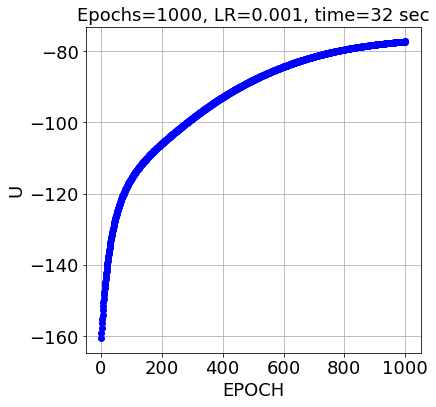

In [11]:
print(vocab)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (2,8)

epochs = range(1, len(U_array)+1)
plt.plot(epochs, U_array, 'bo')

plt.title(ttl, fontsize=18)
plt.xlabel('EPOCH', fontsize=18)
plt.ylabel('U', fontsize=18)
plt.grid()
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)

vocab_df['embedding']=[v for v in  W0.cpu().detach().numpy()]
vocab_df

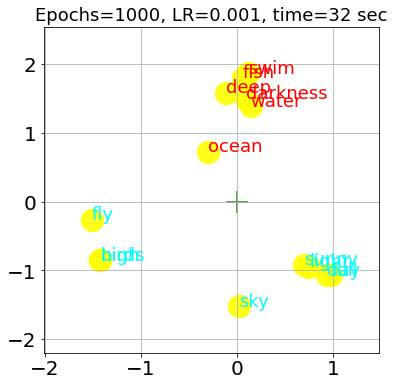

In [13]:
plot_words_v0(W0.cpu().detach().numpy(), vocab, ttl=ttl, wcolor=vocab_df.color)